In [4]:
#load and vis a few seqmented images in the images_CNN folder
import os
import glob
import h5py
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from PIL import Image, ImageSequence
img_list = glob.glob('images_CNN/F?_im.TIF')+glob.glob('images_CNN/F??_im.TIF')
img_list = sorted(img_list)
mask_list = glob.glob('images_CNN/*mask.h5')
mask_list = sorted(mask_list)
fluo_gfp = glob.glob('images_CNN/*GFP_im.TIF')
fluo_gfp = sorted(fluo_gfp)
fluo_rfp = glob.glob('images_CNN/*RFP_im.TIF')
fluo_rfp = sorted(fluo_rfp)
print( len(img_list), len(mask_list) , len(fluo_gfp), len(fluo_rfp  )   )
dataset = {}
for i in range(len(img_list)):
    dataset[i] = { 'img': img_list[i], 'mask': mask_list[i], 'gfp': fluo_gfp[i], 'rfp': fluo_rfp[i]  }
print(dataset)

11 11 11 11
{0: {'img': 'images_CNN/F10_im.TIF', 'mask': 'images_CNN/F10_mask.h5', 'gfp': 'images_CNN/F10_GFP_im.TIF', 'rfp': 'images_CNN/F10_RFP_im.TIF'}, 1: {'img': 'images_CNN/F11_im.TIF', 'mask': 'images_CNN/F11_mask.h5', 'gfp': 'images_CNN/F11_GFP_im.TIF', 'rfp': 'images_CNN/F11_RFP_im.TIF'}, 2: {'img': 'images_CNN/F1_im.TIF', 'mask': 'images_CNN/F1_mask.h5', 'gfp': 'images_CNN/F1_GFP_im.TIF', 'rfp': 'images_CNN/F1_RFP_im.TIF'}, 3: {'img': 'images_CNN/F2_im.TIF', 'mask': 'images_CNN/F2_mask.h5', 'gfp': 'images_CNN/F2_GFP_im.TIF', 'rfp': 'images_CNN/F2_RFP_im.TIF'}, 4: {'img': 'images_CNN/F3_im.TIF', 'mask': 'images_CNN/F3_mask.h5', 'gfp': 'images_CNN/F3_GFP_im.TIF', 'rfp': 'images_CNN/F3_RFP_im.TIF'}, 5: {'img': 'images_CNN/F4_im.TIF', 'mask': 'images_CNN/F4_mask.h5', 'gfp': 'images_CNN/F4_GFP_im.TIF', 'rfp': 'images_CNN/F4_RFP_im.TIF'}, 6: {'img': 'images_CNN/F5_im.TIF', 'mask': 'images_CNN/F5_mask.h5', 'gfp': 'images_CNN/F5_GFP_im.TIF', 'rfp': 'images_CNN/F5_RFP_im.TIF'}, 7: {'i

In [9]:
from PIL import Image, ImageEnhance
def adjust_brightness_contrast(input_image_path, output_image_path, brightness=3, contrast=3):
    # Open the image
    image = Image.open(input_image_path)
    
    # Adjust brightness
    enhancer = ImageEnhance.Brightness(image)
    image = enhancer.enhance(brightness)
    
    # Adjust contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(contrast)
    
    # Save the modified image
    image.save(output_image_path)

In [10]:
import skimage.measure as measure
import copy
def output_contours( m , cl , verbose = False):

    c = []
    for val in list(np.unique(m)):
        sub = copy.deepcopy(m)
        sub[sub!=val]= 0
        c+= measure.find_contours(sub, .9)
    contours = c
    
    if verbose == True:
        plt.imshow(m)
        plt.title( 'contours ' + str(cl) ) 
        for n, contour in enumerate(contours):
            plt.plot(contour[:, 1], contour[:, 0], linewidth=2)
        plt.show()

    #output contours of each mask to file
    #divide x and y coordinates by total image size
    #to get values between 0 and 1  
    #<class-index> <x1> <y1> <x2> <y2> ... <xn> <yn>
    lines = []
    
    for c in contours:
        coords = []
        for i in range(0,c.shape[0]):
            coords.append( (float(c[i][1]) / m.shape[0]) )
            coords.append( (float(c[i][0]) / m.shape[1]) )
        line = str(cl) + ' ' + ' '.join([str(c) for c in coords]) + '\n'
        lines.append(line)
    return lines

def split_mask(mask, crop = 1024):
    #custom encoding with 3 classes
    mask = mask[0:crop, 0:crop]
    mask1 = copy.deepcopy(mask)
    mask1[mask1 > 1000] =  0
    
    mask2 = copy.deepcopy(mask)
    mask2[mask2 < 1000 ] = 0
    mask2[mask2 > 2000 ] = 0
    
    mask3 = copy.deepcopy(mask)
    mask3[ (mask3 < 2000) ] =  0
    
    return mask1, mask2, mask3

def mask2contourfile( mask , outputfile , verbose = False):
    if type(mask) == list:
        m1,m2,m3 = mask
    else:
        m1, m2, m3 = split_mask(mask)
    lines = output_contours(m1, 0 , verbose = verbose)
    lines += output_contours(m2, 1, verbose = verbose)
    lines += output_contours(m3, 2, verbose = verbose)
    
    with open(outputfile, 'w') as f:
        for l in lines:
            f.write(l)
    return  outputfile


In [11]:
#clean finaldataset folder
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree('./datasets/')
    except:
        pass
    os.mkdir('./datasets/')
    os.mkdir('./datasets/train')
    os.mkdir('./datasets/train/images/')
    os.mkdir('./datasets/train/labels/')
    
    os.mkdir('./datasets/test')
    os.mkdir('./datasets/test/images/')
    os.mkdir('./datasets/test/labels/')
    
    os.mkdir('./datasets/val/')
    os.mkdir('./datasets/val/images')
    os.mkdir('./datasets/val/labels')


In [15]:
import pickle
with open('scalers.pkl' , 'rb') as scalerdump:
    scalers = pickle.loads( scalerdump.read())
print(scalers)

[RobustScaler()]


In [16]:
#stack equivalent frames together from img, gfp and rfp and transform them to a jpg image
import cv2
import numpy as np
import os
import tqdm

verbose = False
crop = 1024



def yield_frames(img,crop=1024 , verbose = False ,scaler = True):
    for i, page in enumerate(ImageSequence.Iterator(img)):
        if verbose == True:
            plt.imshow(np.array(page))
            plt.show()
        if crop is not None:
            page = np.array(page)[0:crop, 0:crop]
        if scaler==True:
            page = (page - page.min()) / (page.max() - page.min()) * 255
        yield page

count = 0

for sample in dataset:
    maskfile = dataset[sample]['mask']
    maskh5 = h5py.File(maskfile, 'r')
    for group in maskh5.keys():
        for frame in maskh5[group]:
            mask = np.array( maskh5[group][frame] ,  dtype = np.uint16 )
            
            if np.sum(mask) > 0 :
                mask =  mask[0:crop, 0:crop]
                dataset[sample]['maskmatrix'] = mask
                print( group, frame)
                print(np.unique(mask) )
                if verbose == True:
                    plt.imshow(mask)
                    plt.show()
                converted = mask2contourfile(mask, maskfile +'converted.txt' , verbose = verbose)
                dataset[sample]['mask_poly'] = converted
                break

    print('loading img')
    img = Image.open(dataset[sample]['img'])
    img = [frame for frame in yield_frames(img,scaler = True , verbose=verbose)]
    print('loading gfp')
    
    gfp = Image.open(dataset[sample]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,scaler = True,verbose=verbose)]
    
    print('loading rfp')
    rfp = Image.open(dataset[sample]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,scaler = True,verbose=verbose)]
    dataset[sample]['stack']= []
    dataset[sample]['stack_mat'] ={}
    #stack the frames together
    for i in tqdm.tqdm(range(len(img))):
        im = np.stack([img[i], gfp[i], rfp[i]], axis=-1)
        dataset[sample]['stack_mat'][i] = im

        #im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
        
        cv2.imwrite('./datasets/train/images/img_'+str(count)+'.png', im )
        #adjust_brightness_contrast('./datasets/train/images/img_'+str(count)+'.png','./datasets/train/images/img_'+str(count)+'.png')

        dataset[sample]['stack'].append('./datasets/train/images/img_'+str(count)+'.png')
        
        #save the correct mask file
        shutil.copyfile(dataset[sample]['mask_poly'], './datasets/train/labels/img_'+str(count)+'.txt' )
        count += 1

FOV0 T5
[   0    1    2    4 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1020 1021 2001 2002 2003]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.34it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1020 1021 1022 1023 2001 2002]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 17.27it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8   10   11 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1031 1032 1033 1034 1035 1037 1038 1039 1042 1043 1044 2001 2002 2003 2004 2005 2006 2007 2008 2009 2011]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.51it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   13 1001 1002 1003 1004 1007 1008 1009 1010 1013 1014 1015 1016 1017 1018 1020 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1046 1047 1048 1049 1050 1051 1052 1053 1054 1055 1056 1059
 1060 1061 1062 1063 1064 1065 1066 1075 1076 1077 1078 2001 2002 2003 2006]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.36it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020 1021 1022 1023 1024 1025 1026 1028 1032 1033 1039 1040 2001 2002 2003 2004 2005 2006 2007 2008 2009 2014]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 18.22it/s]


FOV0 T5
[   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16   17   21 1001 1003 1004 1005 1006 1007 1009 1010 1011 1012 1013 1014 1015 1017 1018 1019 1020 1021 1022 1023 1026 1027 1028 1029 1030 1031 1032 1033 1034 1036 1037 1038 1039 1051 2001 2002 2003 2004 2005 2011 2012]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.40it/s]


FOV0 T5
[   0    1    2    3    6    7 1001 1002 1003 1004 1005 1006 1007 1008 1012 1013 1015 1016 1017 1019 1020 1021 1022 1024 2001 2002 2003 2004 2006]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.18it/s]


FOV0 T5
[   0    1    2 1001 1002 1003 1004 1005 1007]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.50it/s]


FOV0 T5
[   0 1001 1002 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.10it/s]


FOV0 T5
[   0    1    2    4 1001 1003 1004 1005 1006 1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1018 1019 1020 1021 1022 1023 1025 1029 1035 2001 2002]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.30it/s]


FOV0 T5
[   0    1    2    3    4 1001 1002 1003 1004 1005 1006 1007 1008 1009 1011 1012 1013 1014 1015 1016 1023 2002 2003]
loading img
loading gfp
loading rfp


100%|████| 7/7 [00:00<00:00, 19.31it/s]


loading img
loading gfp
loading rfp


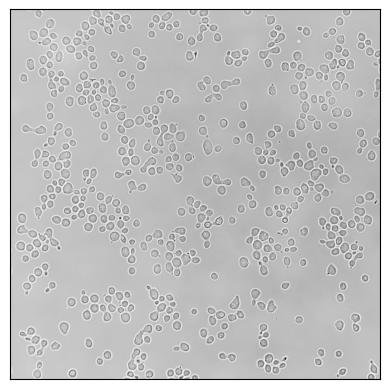

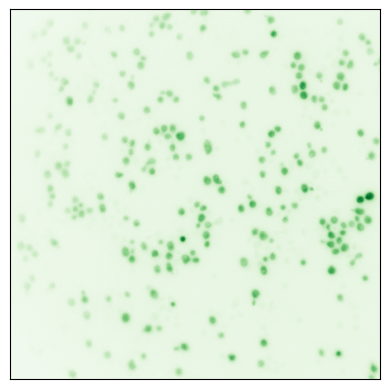

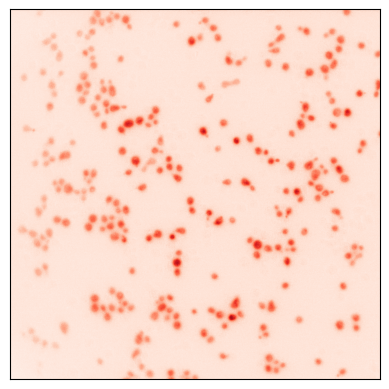

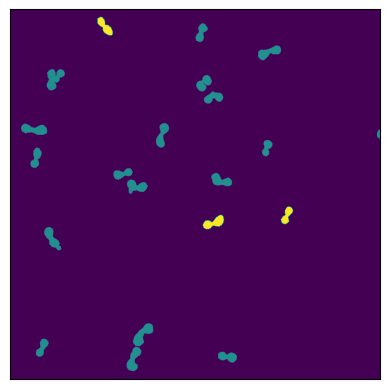

In [17]:
check_example = True
import matplotlib.pyplot as plt
%matplotlib inline

if check_example == True:
    print('loading img' )
    img = Image.open(dataset[0]['img'])
    img = [frame for frame in yield_frames(img,verbose=False)]
    print('loading gfp')

    gfp = Image.open(dataset[0]['gfp'])
    gfp = [frame for frame in yield_frames(gfp,verbose=False)]
    
    print('loading rfp')
    rfp = Image.open(dataset[0]['rfp'])
    rfp = [frame for frame in yield_frames(rfp,verbose=False)]

    ax = plt.imshow( img[0] , cmap = 'Greys')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( gfp[0] , cmap = 'Greens')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    ax = plt.imshow( rfp[0] , cmap = 'Reds')
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    
    ax = plt.imshow( dataset[0]['maskmatrix'] )
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])

    plt.show()
    
    


In [18]:
from sklearn.preprocessing import RobustScaler
import numpy as np
import pickle



# Initialize the RobustScaler
scaler_bf = RobustScaler()

images_bf = np.stack([ dataset[sample]['stack_mat'][frame] for sample in dataset for frame in dataset[sample]['stack_mat'] ])
print('stacks' , images_bf.shape)

image_stack_bf = images_bf.reshape(-1, images_bf.shape[0])

print( 'fitting scalers ' ) 
scaler_bf.fit(image_stack_bf)

scalers = [scaler_bf]
print('scalers', scalers)
with open('scalers.pkl' , 'wb') as scalerdump:
    scalerdump.write(pickle.dumps(scalers))

stacks (77, 1024, 1024, 3)
fitting scalers 
scalers [RobustScaler()]


In [19]:
#apply data augmentation
#image augmentation for training

import cv2
import random
import numpy as np

def random_rotation(image, masks, angle_range):
    angle = random.uniform(-angle_range, angle_range)
    image =  Image.fromarray(  np.array( np.ones(image.shape)*256 - Image.fromarray(image)).astype(np.uint8) )
    image = image.rotate(angle)
    masks = [ Image.fromarray(m) for m in masks ]
    masks = [ m.rotate(angle) for m in masks ]
    return np.array(image), masks

def random_flip(image, masks):
    if random.random() > 0.5:
        image = cv2.flip(image, 1)
        masks = [ cv2.flip(np.array(m), 1) for m in masks]
    return image, masks

def random_augmentation(image, masks, angle_range, crop_size):
    
    image, masks = random_rotation(image, masks, angle_range)
    
    image, masks = random_flip(image, masks)
   
    
    #image, mask = random_crop(image, mask, crop_size)
    return image, masks

#resize to original size
def resize(image, mask, size):
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    return image, mask

#apply augmentation and then resize to original size
def augment_and_resize(image, masks, angle_range=180, crop_size=900, size=[1024,1024]):
    image = image.astype(np.uint8)
    image, masks = random_augmentation(image, masks, angle_range, crop_size)
    masks = [np.array(m) for m in masks ]
    #image, masks = resize(image, masks, size)
    return image, masks

In [20]:

augmented_folder = 'augmented/'

In [21]:
import shutil
overwite = True
if overwite:
    try:
        shutil.rmtree(augmented_folder)
    except:
        pass
    os.mkdir(augmented_folder)
    os.mkdir(augmented_folder+'train')
    os.mkdir(augmented_folder+'train/images/')
    os.mkdir(augmented_folder+'train/labels/')
    os.mkdir(augmented_folder +'test')
    os.mkdir(augmented_folder+'test/images/')
    os.mkdir(augmented_folder + 'test/labels/')
    os.mkdir(augmented_folder +'val/')
    os.mkdir(augmented_folder +'val/images')
    os.mkdir(augmented_folder + 'val/labels')


In [ ]:
verbose = False
import tqdm 
x_augment = 10
augmented = {}

count = 0
for sample in tqdm.tqdm(dataset):
    augmented[sample] ={}
    for frame in dataset[sample]['stack_mat']:
        image = dataset[sample]['stack_mat'][frame]
        mask = dataset[sample]['maskmatrix']
        masks = split_mask(mask)
        for i in range(x_augment):
            img , masks = augment_and_resize(image,masks)
            
            for m in masks:
                m[m>0] = 1
                
            if count < 10 and verbose == True:
                plt.imshow( img[:,:,0] , cmap = 'Greys')
                plt.colorbar( location = 'left')
                plt.show()
            augmented[sample]['mask'] = mask
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(augmented_folder+'train/images/img_'+str(count)+'.png', im )
            augmented[sample]['img'] = augmented_folder+'train/images/img_'+str(count)+'.png'
            m1,m2,m3 = masks
            lines = output_contours(m1, 0 , verbose = verbose)
            lines += output_contours(m2, 1, verbose = verbose)
            lines += output_contours(m3, 2, verbose = verbose)
            with open(augmented_folder + 'train/labels/img_'+ str(count)+ '.txt', 'w') as f:
                for l in lines:
                    f.write(l)
            augmented[sample]['mask_poly'] = augmented_folder  +'train/labels/img_'+ str(count)+ '.txt'
            #add polygons
            count+=1
            

 73%|██▏| 8/11 [02:43<00:59, 19.79s/it]

In [1]:
#move a fraction of the training data and corresponding labels to val
import random
import shutil
import os

datasetdir = 'datasets/'#augmented_folder

files = os.listdir(datasetdir +'train/images/')
print(files[0:100], '...')
random.shuffle(files)
val_files = files[:int(len(files)*.1)]
for f in val_files:
    shutil.move(datasetdir + 'train/images/'+f, datasetdir+'val/images/'+f)
    shutil.move(datasetdir +'train/labels/'+f.replace('.png', '.txt'), datasetdir + 'val/labels/'+f.replace('.png', '.txt'))

    
files = os.listdir(datasetdir+'train/images/')
random.shuffle(files)

test_files = files[:int(len(files)*.1)]
for f in test_files:
    shutil.move(datasetdir + 'train/images/'+f, datasetdir + 'test/images/'+f)
    shutil.move(datasetdir + 'train/labels/'+f.replace('.png', '.txt'), datasetdir + 'test/labels/'+f.replace('.png', '.txt'))



['img_60.png', 'img_51.png', 'img_9.png', 'img_70.png', 'img_76.png', 'img_57.png', 'img_48.png', 'img_58.png', 'img_26.png', 'img_30.png', 'img_74.png', 'img_24.png', 'img_53.png', 'img_14.png', 'img_20.png', 'img_35.png', 'img_19.png', 'img_10.png', 'img_36.png', 'img_25.png', 'img_1.png', 'img_73.png', 'img_31.png', 'img_37.png', 'img_0.png', 'img_40.png', 'img_71.png', 'img_44.png', 'img_17.png', 'img_8.png', 'img_28.png', 'img_32.png', 'img_13.png', 'img_5.png', 'img_38.png', 'img_47.png', 'img_11.png', 'img_54.png', 'img_16.png', 'img_55.png', 'img_67.png', 'img_52.png', 'img_49.png', 'img_29.png', 'img_7.png', 'img_23.png', 'img_12.png', 'img_3.png', 'img_43.png', 'img_2.png', 'img_64.png', 'img_6.png', 'img_61.png', 'img_63.png', 'img_4.png', 'img_59.png', 'img_50.png', 'img_21.png', 'img_66.png', 'img_56.png', 'img_18.png', 'img_41.png', 'img_72.png'] ...


In [2]:
#create traininging yaml file for the dataset
outyaml = """
train: train
val: val
test: test

names: 
    0: f
    1: h
    2: l


# Hyperparameters ------------------------------------------------------------------------------------------------------
# lr0: 0.01  # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
# lrf: 0.01  # final learning rate (lr0 * lrf)
# momentum: 0.937  # SGD momentum/Adam beta1
# weight_decay: 0.0005  # optimizer weight decay 5e-4
# warmup_epochs: 3.0  # warmup epochs (fractions ok)
# warmup_momentum: 0.8  # warmup initial momentum
# warmup_bias_lr: 0.1  # warmup initial bias lr
# box: 7.5  # box loss gain
# cls: 0.5  # cls loss gain (scale with pixels)
# dfl: 1.5  # dfl loss gain
# pose: 12.0  # pose loss gain
# kobj: 1.0  # keypoint obj loss gain
# label_smoothing: 0.0  # label smoothing (fraction)
# nbs: 64  # nominal batch size
# hsv_h: 0.015  # image HSV-Hue augmentation (fraction)
# hsv_s: 0.7  # image HSV-Saturation augmentation (fraction)
# hsv_v: 0.4  # image HSV-Value augmentation (fraction)
# degrees: 0.0  # image rotation (+/- deg)
translate: 0.1  # image translation (+/- fraction)
scale: 0.2  # image scale (+/- gain)
shear: 0.2  # image shear (+/- deg) from -0.5 to 0.5
perspective: 0.1  # image perspective (+/- fraction), range 0-0.001
flipud: 0.7  # image flip up-down (probability)
fliplr: 0.5  # image flip left-right (probability)
mosaic: 0.3  # image mosaic (probability)
mixup: 0.1  # image mixup (probability)
# copy_paste: 0.0  # segment copy-paste (probability)
"""

with open('./dataset.yaml', 'w') as f:
    f.write(outyaml)

In [3]:
hyp = {}

hyp['lr0']= 0.001 # initial learning rate (i.e. SGD=1E-2, Adam=1E-3)
hyp['lrf']= 0.0001 # final learning rate (lr0 * lrf)
hyp['momentum']= 0.5 # SGD momentum/Adam beta1
hyp['weight_decay']= 0.0001 # optimizer weight decay 5e-4
hyp['warmup_epochs']= 3.0 # warmup epochs (fractions ok)
hyp['warmup_momentum']= 0.8 # warmup initial momentum
hyp['warmup_bias_lr']= 0.01 # warmup initial bias lr
hyp['box']= 10 # box loss gain
hyp['cls']= 5 # cls loss gain (scale with pixels)
hyp['dfl']= .5 # dfl loss gain
hyp['pose']= 0 # pose loss gain
hyp['kobj']= 0 # keypoint obj loss gain
hyp['label_smoothing']= 0.0 # label smoothing (fraction)
hyp['nbs']= 64 # nominal batch size
hyp['hsv_h']= 0.01 # image HSV-Hue augmentation (fraction)
hyp['hsv_s']= 0.01 # image HSV-Saturation augmentation (fraction)
hyp['hsv_v']= 0.01 # image HSV-Value augmentation (fraction)
hyp['degrees']= 90.0 # image rotation (+/- deg)
hyp['translate']= 0.1 # image translation (+/- fraction)
hyp['scale']= 0.1 # image scale (+/- gain)
hyp['shear']= 0.0 # image shear (+/- deg)
hyp['perspective']= 0.0 # image perspective (+/- fraction), range 0-0.001
hyp['flipud']= 0.5 # image flip up-down (probability)
hyp['fliplr']= 0.5 # image flip left-right (probability)
hyp['mosaic']= 0.0 # image mosaic (probability)
hyp['mixup']= 0.0 # image mixup (probability)
hyp['copy_paste']= 0.0 # segment copy-paste (probability)



In [4]:
from ultralytics import YOLO
modelpath = 'yolov8n-seg_yfusion.pt'
import os

overwrite = False
if os.path.exists(modelpath) and overwrite == False:
    model = YOLO(modelpath)
else:
    #train the model
    model = YOLO("yolov8n-seg.pt")

In [ ]:
train = True
if train == True:
    results = model.train(
            batch=1,
            device=0,
            data='./dataset.yaml',
            epochs=2000,
            imgsz=1024,
            ** hyp
        )

Ultralytics YOLOv8.1.30 🚀 Python-3.11.6 torch-2.2.0 CUDA:0 (Quadro RTX 4000, 7949MiB)
engine/trainer: task=segment, mode=train, model=yolov8n-seg_yfusion.pt, data=./dataset.yaml, epochs=2000, time=None, patience=100, batch=1, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train50, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show

train: Scanning /home/dmoi/projects/yea

train: New cache created: /home/dmoi/projects/yeast_fusion_segmenter/datasets/train/labels.cache



val: Scanning /home/dmoi/projects/yeast

val: New cache created: /home/dmoi/projects/yeast_fusion_segmenter/datasets/val/labels.cache


Plotting labels to runs/segment/train50/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.001' and 'momentum=0.5' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 66 weight(decay=0.0), 77 weight(decay=0.0001), 76 bias(decay=0.0)
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/segment/train50
Starting training for 2000 epochs...

      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     1/2000      4.54G      1.855      
                 Class     Images  Inst

                   all         13        477   0.000313    0.00098   0.000989   9.89e-05          0          0          0          0



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     2/2000      6.28G      1.716      
                 Class     Images  Inst

                   all         13        477      0.605      0.195      0.207      0.138      0.601      0.185      0.194     0.0976



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     3/2000       3.7G       1.65      
                 Class     Images  Inst

                   all         13        477      0.605      0.195      0.207      0.138      0.601      0.185      0.194     0.0976



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     4/2000      2.12G       1.79      
                 Class     Images  Inst

                   all         13        477      0.523      0.315      0.143     0.0811       0.48       0.23     0.0897     0.0339



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     5/2000      6.29G      1.814      
                 Class     Images  Inst

                   all         13        477      0.592      0.239      0.194      0.111      0.592      0.239       0.19     0.0916



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     6/2000      5.62G      1.712      
                 Class     Images  Inst

                   all         13        477      0.556      0.331      0.226      0.141      0.503      0.265      0.142     0.0564



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     7/2000      2.28G      1.668      
                 Class     Images  Inst

                   all         13        477      0.292      0.343      0.273      0.181      0.289      0.341      0.266      0.162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     8/2000      4.33G      1.643      
                 Class     Images  Inst

                   all         13        477      0.292      0.343      0.273      0.181      0.289      0.341      0.266      0.162



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


     9/2000      2.21G       1.64      
                 Class     Images  Inst

                   all         13        477      0.335      0.278      0.299        0.2      0.325       0.28      0.291      0.178



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    10/2000      3.24G      1.623      
                 Class     Images  Inst

                   all         13        477       0.31      0.309      0.327       0.21      0.314      0.316      0.332       0.19



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    11/2000      4.98G      1.595      
                 Class     Images  Inst

                   all         13        477      0.307      0.401      0.351      0.234      0.318      0.381      0.355      0.213



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    12/2000      5.65G      1.642      
                 Class     Images  Inst

                   all         13        477      0.747      0.309      0.375      0.224      0.748      0.309      0.371      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    13/2000      3.48G      1.606      
                 Class     Images  Inst

                   all         13        477      0.747      0.309      0.375      0.224      0.748      0.309      0.371      0.208



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    14/2000      2.22G      1.539      
                 Class     Images  Inst

                   all         13        477      0.803      0.333      0.417      0.284      0.803      0.333      0.413      0.236



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    15/2000      2.32G      1.481      
                 Class     Images  Inst

                   all         13        477      0.796      0.392       0.44      0.318      0.796      0.392       0.44      0.267



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    16/2000      5.54G      1.431      
                 Class     Images  Inst

                   all         13        477      0.783       0.41      0.471      0.327      0.783       0.41      0.468      0.272



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    17/2000      6.52G      1.398      
                 Class     Images  Inst

                   all         13        477      0.518      0.448      0.484      0.355      0.523      0.452      0.486       0.31



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    18/2000      5.17G      1.363      
                 Class     Images  Inst

                   all         13        477       0.42      0.517        0.5      0.367       0.42      0.517      0.504      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    19/2000      4.89G      1.364      
                 Class     Images  Inst

                   all         13        477       0.42      0.517        0.5      0.367       0.42      0.517      0.504      0.331



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    20/2000      4.61G      1.327      
                 Class     Images  Inst

                   all         13        477      0.444      0.544      0.506      0.374      0.444      0.544      0.515      0.343



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    21/2000      5.76G      1.335      
                 Class     Images  Inst

                   all         13        477       0.61      0.498      0.518      0.371      0.607      0.494      0.513      0.326



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    22/2000      4.77G       1.28      
                 Class     Images  Inst

                   all         13        477      0.536      0.473      0.529      0.391      0.533      0.469      0.524      0.328



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    23/2000      4.33G       1.26      
                 Class     Images  Inst

                   all         13        477      0.599      0.482      0.521      0.402      0.599      0.482      0.521       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    24/2000      2.35G      1.234      
                 Class     Images  Inst

                   all         13        477      0.599      0.482      0.521      0.402      0.599      0.482      0.521       0.34



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    25/2000      3.75G      1.358      
                 Class     Images  Inst

                   all         13        477      0.635      0.497      0.536      0.402      0.634      0.496      0.538      0.366



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    26/2000      6.76G      1.325      
                 Class     Images  Inst

                   all         13        477       0.81      0.459       0.54      0.402      0.807      0.455      0.536      0.362



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    27/2000      6.62G      1.314      
                 Class     Images  Inst

                   all         13        477       0.73      0.446      0.524      0.378       0.74      0.447      0.527      0.332



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    28/2000      4.49G      1.303      
                 Class     Images  Inst

                   all         13        477      0.835      0.439      0.567       0.39      0.835      0.439      0.567      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    29/2000      5.23G      1.305      
                 Class     Images  Inst

                   all         13        477      0.835      0.439      0.567       0.39      0.835      0.439      0.567      0.351



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    30/2000      4.22G      1.237      
                 Class     Images  Inst

                   all         13        477      0.654      0.515      0.556      0.395      0.658      0.519       0.56      0.353



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    31/2000      6.69G      1.203      
                 Class     Images  Inst

                   all         13        477      0.616      0.495       0.55      0.402      0.616      0.495      0.547      0.354



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    32/2000      2.73G      1.187      
                 Class     Images  Inst

                   all         13        477      0.657      0.501      0.553      0.422      0.661      0.499      0.551      0.377



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    33/2000      4.24G      1.179      
                 Class     Images  Inst

                   all         13        477      0.496      0.617      0.574      0.442      0.498      0.622      0.573      0.398



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    34/2000      2.23G      1.165      
                 Class     Images  Inst

                   all         13        477      0.515      0.583      0.584      0.441      0.587      0.555      0.579      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    35/2000      5.38G      1.143      
                 Class     Images  Inst

                   all         13        477      0.515      0.583      0.584      0.441      0.587      0.555      0.579      0.395



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    36/2000         5G      1.138      
                 Class     Images  Inst

                   all         13        477      0.583      0.576      0.589      0.441      0.587      0.574      0.589      0.387



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    37/2000      6.05G      1.128      
                 Class     Images  Inst

                   all         13        477      0.512      0.636      0.604      0.448      0.502      0.622      0.599      0.383



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    38/2000      3.64G      1.146      
                 Class     Images  Inst

                   all         13        477      0.601      0.628      0.631      0.499      0.602      0.622      0.625       0.44



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    39/2000      4.33G      1.116      
                 Class     Images  Inst

                   all         13        477      0.639      0.644      0.638        0.5       0.63      0.636      0.629      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    40/2000      4.51G      1.106      
                 Class     Images  Inst

                   all         13        477      0.639      0.644      0.638        0.5       0.63      0.636      0.629      0.464



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    41/2000      5.21G      1.125      
                 Class     Images  Inst

                   all         13        477      0.676      0.658      0.655      0.507      0.671      0.638       0.65       0.46



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    42/2000      3.55G      1.122      
                 Class     Images  Inst

                   all         13        477      0.677      0.653      0.673      0.498      0.678       0.65      0.672      0.432



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    43/2000      5.17G        1.1      
                 Class     Images  Inst

                   all         13        477      0.698      0.667      0.679      0.495      0.708      0.676      0.692      0.417



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    44/2000      5.45G      1.117      
                 Class     Images  Inst

                   all         13        477      0.723      0.658      0.687      0.517      0.727       0.66      0.693      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    45/2000      2.25G      1.082      
                 Class     Images  Inst

                   all         13        477      0.723      0.658      0.687      0.517      0.727       0.66      0.693      0.443



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    46/2000      5.62G      1.105      
                 Class     Images  Inst

                   all         13        477      0.727      0.671        0.7      0.537      0.727      0.671      0.702      0.478



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    47/2000      3.54G      1.161      
                 Class     Images  Inst

                   all         13        477      0.747      0.633      0.693      0.541      0.747      0.633      0.694      0.477



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    48/2000      4.09G      1.111      
                 Class     Images  Inst

                   all         13        477       0.76      0.643      0.722      0.561       0.76      0.643       0.72      0.505



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    49/2000      2.81G      1.108      
                 Class     Images  Inst

                   all         13        477      0.745      0.672      0.733      0.548      0.745      0.672      0.733      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    50/2000      5.69G      1.128      
                 Class     Images  Inst

                   all         13        477      0.679      0.689       0.72      0.541      0.682      0.694      0.726      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    51/2000      2.18G      1.063      
                 Class     Images  Inst

                   all         13        477      0.679      0.689       0.72      0.541      0.682      0.694      0.726      0.461



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    52/2000      3.98G       1.08      
                 Class     Images  Inst

                   all         13        477      0.767      0.658      0.712      0.563      0.767      0.658      0.721      0.496



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    53/2000      6.42G      1.097      
                 Class     Images  Inst

                   all         13        477      0.707       0.71      0.718      0.569      0.707       0.71      0.725      0.514



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    54/2000      4.78G      1.111      
                 Class     Images  Inst

                   all         13        477      0.743      0.701      0.731       0.58      0.743      0.701      0.734      0.502



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    55/2000      4.03G      1.026      
                 Class     Images  Inst

                   all         13        477      0.792       0.68      0.741      0.567      0.792       0.68      0.742      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    56/2000      2.24G      1.059      
                 Class     Images  Inst

                   all         13        477      0.792       0.68      0.741      0.567      0.792       0.68      0.742      0.484



      Epoch    GPU_mem   box_loss   seg_loss   cls_loss   dfl_loss  Instances       Size


    57/2000      2.24G        1.1      

In [ ]:
#save model
model.save('yolov8n-seg_yfusion.pt')

In [ ]:
import glob
import cv2
from matplotlib import pyplot as plt
functional_testing_set = glob.glob('./validation/mprm1-mprm1-entr/*.tif' )
print( functional_testing_set[0 ] )
print(cv2.imread(functional_testing_set[0 ]).shape)

cscheme = [ 'Greys' , 'Greens', 'Reds' ]
sample = cv2.imread(functional_testing_set[0 ])
for channel in range(sample.shape[2] ):
    plt.imshow(sample[:,:,channel] , cmap = cscheme[channel])
    plt.colorbar()
    plt.show()

In [9]:
import pickle
#my_model = YOLO('yolov8n-seg_yfusion.pt')
my_model = YOLO('yolov8n-seg_yfusion.pt')

#my_model = model
def scaleimg(imgfile):
    #scale each input channel
    im = cv2.imread(imgfile)
    for d in range(im.shape[2]):
        page = im[:,:,d]
        page = (page - page.min()) / (page.max() - page.min()) * 255
        im[:,:,d] = page
    #im = cv2.cvtColor(im, cv2.COLOR_RGB2BGR)
    cv2.imwrite(imgfile +'_scaled.png', im )
    adjust_brightness_contrast(imgfile +'_scaled.png',imgfile +'_scaled.png')
    
    return imgfile +'_scaled.png'

functional_testing_set = glob.glob('./validation/mprm1-mprm1-entr/*.tif' )
predinput = [scaleimg(i) for i in functional_testing_set ]
results = { img:my_model( img , conf=0.0) for img in predinput }
with open( 'functional_test.pkl' , 'wb' ) as resout:
    resout.write( pickle.dumps( results ))

NameError: name 'adjust_brightness_contrast' is not defined

In [6]:
print(results.keys())

dict_keys(['./validation/mprm1-mprm1-entr/GFP_Position007.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position001.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position005.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position005.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position010.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position005.tif_scaled.png', './validation/mprm1-mprm1-entr/BF_Position007.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position009.tif_scaled.png', './validation/mprm1-mprm1-entr/GFP_Position010.tif_scaled.png', './validation/mprm1-mprm1-entr/RFP_Position007.tif_scaled.png'])


In [19]:
from matplotlib import patches
import tqdm

def add_rect(h,w,x,y , ax , color = 'r', label= '' ):
    # Create a Rectangle patch
    rect = patches.Rectangle((y,x), h, w, linewidth=3, edgecolor=color, facecolor='none')
    # Add the patch to the Axes
    ax.add_patch(rect)
    if len(label) > 0:
        ax.text(y - 20, x - 20 , label , )
    return ax

def plot_res(pred, imgfile):
    
    img = pred[0].orig_img
    boxes = pred[0].boxes.xywh.detach().cpu()
    c = pred[0].boxes.cls.detach().cpu()
    print(boxes)
    fig,axes = plt.subplots(nrows=1, figsize=(20,20)  , ncols=3)

    
    cscheme = [ 'Greys' , 'Greens', 'Reds' ]
    sample = cv2.imread(imgfile)
    
    for channel in range(img.shape[2] ):
        axes[channel].imshow(sample[:,:,channel] , cmap = cscheme[channel])
    for row in tqdm.tqdm(range(boxes.shape[0])):
        x,y,w,h = list( boxes[row,: ] )
        cstr = str(c[row])
        label = str( c[row] )
        for ax in list(axes):
            ax = add_rect(h=h,w=w,x=x,y=y , ax=ax , color = 'r', label= cstr )
    plt.show()


def output_pred(imgfile,my_model=my_model):
    results = list(my_model(imgfile, conf=0.01))
    plot_res(results, imgfile)


image 1/1 /home/dmoi/projects/yeast_fusion_segmenter/validation/mprm1-mprm1-entr/GFP_Position007.tif_scaled.png: 480x640 6 persons, 7 cars, 24 traffic lights, 5.6ms
Speed: 15.3ms preprocess, 5.6ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)
tensor([[  36.3552,  306.4112,   72.4887,  244.8040],
        [ 110.3607,  646.1261,   48.9760,  110.1712],
        [ 448.8336,  970.8110,  189.0311,  106.3780],
        [ 704.1448,  303.1384,   66.9983,   96.3495],
        [  61.5885, 1007.3198,   31.2042,   33.3604],
        [  33.0720,  368.6074,   65.9789,  114.9448],
        [  96.6815, 1007.4551,   31.0789,   30.2653],
        [1038.4658,  441.1431,   80.5390,  125.3031],
        [ 114.3644,  636.4547,   40.6893,   88.8470],
        [ 976.9317,  879.8982,   59.4301,   52.2389],
        [1218.8906,  854.7071,   38.9663,   45.4148],
        [ 431.9229,  960.5329,  169.2249,  126.7639],
        [  33.2078,  349.5175,   65.8904,  166.0049],
        [ 497.1768,   57.5122,   47

100%|████████████████████████████████████████████████████████████████████████████████| 37/37 [00:00<00:00, 590.06it/s]


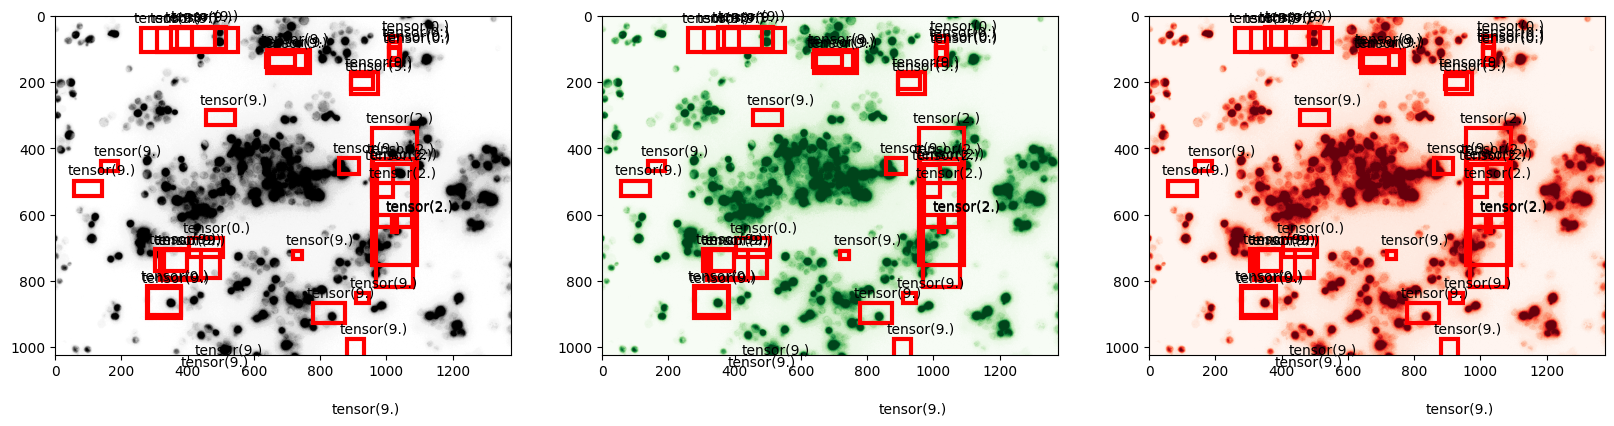

In [20]:
output_pred(predinput[0])

In [21]:
output_pred('datasets/test/images/img_68.png')

FileNotFoundError: datasets/test/images/img_68.png does not exist

In [15]:
#visualize predicitions for the validation set
import random
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tqdm 

my_model = YOLO('runs/segment/train21/weights/best.pt')
results = list(my_model('datasets/test/images/img_57.png', conf=0.0))
result = np.asarray( results[0].conf.detach())
def retdf(model, predfile):
    resdict = { i:{ c:result[row,i] for i,c in enumerate(classes) } for i in result.shape[0] }
    resdf = pd.DataFrame(resdict)
    resdf['file'] = predfile
    return resdf

predfiles = glob.glob('*/')
global_resdf =  pd.concat([ retdf(my_model(imgfile, conf=0.0) ) for imgfile in tqdm.tdm(predfiles) ])

print(global_resdf )

FileNotFoundError: [Errno 2] No such file or directory: 'runs/segment/train21/weights/best.pt'

In [16]:
print(results)

{}


In [17]:
from IPython.display import Image as show_image
show_image(filename="runs/segment/train5/val_batch0_labelsYOLOjpg")

show_image(filename="runs/segment/train5/MaskP_curve.png")

show_image(filename="runs/segment/train5/results.png")



ValueError: Cannot embed the 'runs/segment/train5/val_batch0_labelsyolojpg' image format

In [ ]:
#augment dataset and dump to disk in pt format
